#### República Bolivariana de Venezuela
#### Universidad Centro Occidental Lisandro Alvarado
#### Decanato de Ciencias y Tecnología
#### Ingeniería de Producción

##### Martorana Milko G. C.I.: 24.305.350.

#### Barquisimeto, Mayo, 2022.

## Diseño de Experimentos Estadisticos

### El problema.:  Crecimiento de las platanciones

Contamos con los siguientes 2 parametros.:

- Luz o no.
- Riego bajo o alto.

Entonces creo el experimento.:

### El Objetivo.: 
 - La luz -> minimizar tiempo de exposición
 - El Riego -> minimizar los costos por riego


la cantidad total de experimentos será 2² = 4.

Importo las librerías a utilizar

In [147]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels

In [148]:
Luz = ['On','Off']
Agua = ['Low','High']
# create combinations for all parameters
experimento = [(x,y) for x in Luz for y in Agua]
exp_df = pd.DataFrame(experimento,columns=['A','B'])

Ahora veo las variables

In [149]:
exp_df

,A,B
0,On,Low
1,On,High
2,Off,Low
3,Off,High


Idealmente, cada experimento debe ejecutarse sin la experiencia de intentos anteriores.

In [150]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [151]:
enc = OrdinalEncoder(categories=[['On','Off'],['Low','High']])

In [152]:

encoded_df = pd.DataFrame(enc.fit_transform(exp_df[['A','B']]),columns=['A','B'])
#define the experiments order which must be random
encoded_df['exp_order'] = np.random.choice(np.arange(4),4,replace=False)
encoded_df['outcome'] = [25,37,55,65]
encoded_df

,A,B,exp_order,outcome
0,0.0,0.0,3,25
1,0.0,1.0,0,37
2,1.0,0.0,2,55
3,1.0,1.0,1,65


Explorando un poco el resultado tenemos,

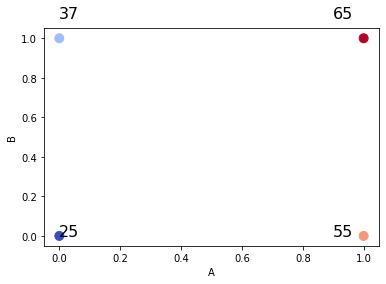

In [153]:
plt.scatter(encoded_df['A'],encoded_df['B'], marker='o', s=80, c=encoded_df['outcome'], cmap='coolwarm')
plt.xlabel('A')
plt.ylabel('B')
for i, txt in enumerate(encoded_df['outcome']):
    plt.annotate(txt, (encoded_df['A'].iloc[i], encoded_df['B'].iloc[i]),xytext=(encoded_df['A'].iloc[i]*0.9, encoded_df['B'].iloc[i]*1.1), fontsize=16)

Es claro que tener A = 1 y B = 1 nos dio los mejores resultados.

In [162]:
promedio = encoded_df['outcome'].mean()
promedio

45.5

El resultado promedio es la media de todos los resultados: 45,5. Esta será nuestra línea de base. A continuación, debemos tener en cuenta los efectos de A y B. Para hacerlo, debemos fijar B(A) y verificar la variación en A(B) y promediar la suma de los efectos.

El efecto promedio de A es, por lo tanto, (30+28)/2 = 29. Podemos ver este resultado de otra manera: observe el gráfico a continuación.

<AxesSubplot:xlabel='A', ylabel='outcome'>

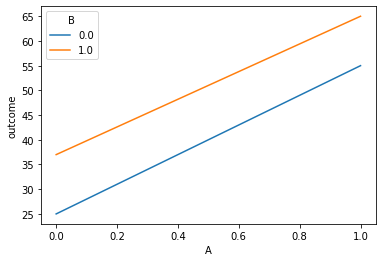

In [155]:
sns.lineplot(x='A',y='outcome',hue='B',data=encoded_df)

Ambas lineas son paralelas. Lo que significa que no tendremos una fórmula en nuestro modelo que los reproduzca: p. un término A*B. Podemos implementar un código simple para calcular los efectos para nosotros:

In [156]:
def Pars_effect(data = encoded_df, par='A', effect='B'):
    data_1 = data[data[par] == data[par].min()]
    data_2 = data[data[par] == data[par].max()]
    
    eff_1 = (data_1[data_1[effect] == data_1[effect].max()].outcome.max() - data_1[data_1[effect] == data_1[effect].min()].outcome.max())
    eff_2 = (data_2[data_2[effect] == data_2[effect].max()].outcome.max() - data_2[data_2[effect] == data_2[effect].min()].outcome.max())
    return (eff_2+eff_1)/2

A continuación, queremos verificar si nuestros coeficientes tienen sentido o no, por lo que implementamos otra pieza de código en la que básicamente sustituimos los coeficientes en nuestra fórmula y asignamos las variables al caso de ±1. Hacemos eso porque es una práctica común usar esta codificación, pero luego veremos qué sucede si hubiéramos usado 0/1 en su lugar.

In [157]:
def predict_outcome(baseline, A, Ax, B, Bx):
    if A == 0:
        A = -1
    if B == 0:
        B = -1
    print(f'y ~ {baseline}+1/2 {Ax}*A + 1/2 {Bx}*B')
    pred_y = baseline + 1/2*Ax*A + 1/2*Bx*B
    print(f'{pred_y}')
    return pred_y

Si probamos nuestra suposición con esta fórmula, podemos comprobar los resultados para el caso de A = 1, B = 1 y A=0, B=0.

In [163]:
Ax = Pars_effect(data = encoded_df, par='B', effect='A')
Bx = Pars_effect(data = encoded_df, par='A', effect='B')
y_predice_1 = predict_outcome(promedio,1,Ax,1,Bx)
y_predice_0 = predict_outcome(promedio,0,Ax,0,Bx)
promedio

y ~ 45.5+1/2 29.0*A + 1/2 11.0*B
65.5
y ~ 45.5+1/2 29.0*A + 1/2 11.0*B
25.5


45.5

Asi obtenemos una formula que puede estimar el resultado de nuestro experimento. Ahora verifiquemos.

In [164]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [160]:
results = smf.ols('outcome ~ A + B', data=encoded_df).fit()

In [165]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     481.0
Date:                Mon, 09 May 2022   Prob (F-statistic):             0.0322
Time:                        02:47:32   Log-Likelihood:                -2.9032
No. Observations:                   4   AIC:                             11.81
Df Residuals:                       1   BIC:                             9.965
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     25.5000      0.866     29.445      0.0

/Users/milkomartorana/micromamba/lib/python3.9/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 4 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


La intercepción es básicamente la mitad del que calculamos mientras que los coeficientes para A y B se duplican. Esto se debe a que en el mapeo ±1 la diferencia entre los dos niveles es 2 mientras que en el mapeo original la diferencia es 1.

### Conclusión

Observamos como planificar un experimento y cómo interpretar los resultados. También vimos cómo descubrir el efecto de las interacciones entre nuestras variables y cómo lidiar con el sobreajuste. Los datos siempre serán la mejor solución, pero en lugar de realizar experimentos aleatorios obtuvimos el marco de donde el cual decidimos como realizarlo.